# Solución de la PC2 del curso de Teoría de Control Automático - 2020
### Autor: Bregy Malpartida
Para la resolución del siguiente examen se uso python y las librerias control, numpy, sympy, *control2020.

(\*) la librería control2020 es un conjunto de funciones útiles para el diseño de diferentes tipos de controladores, es el resultado de la ejecución de varios algoritmos vistos en el curso ya mencionado (UTEC-2020), si se desea profundizar en las distintas implementaciones, estas se encuentran en el siguiente repositorio: https://github.com/bregydoc/controlsystems2020

---

In [1]:
import control as ct
import control2020 as ct20
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt

s = sp.var("s") # symbolic variable to represent the laplace space

---

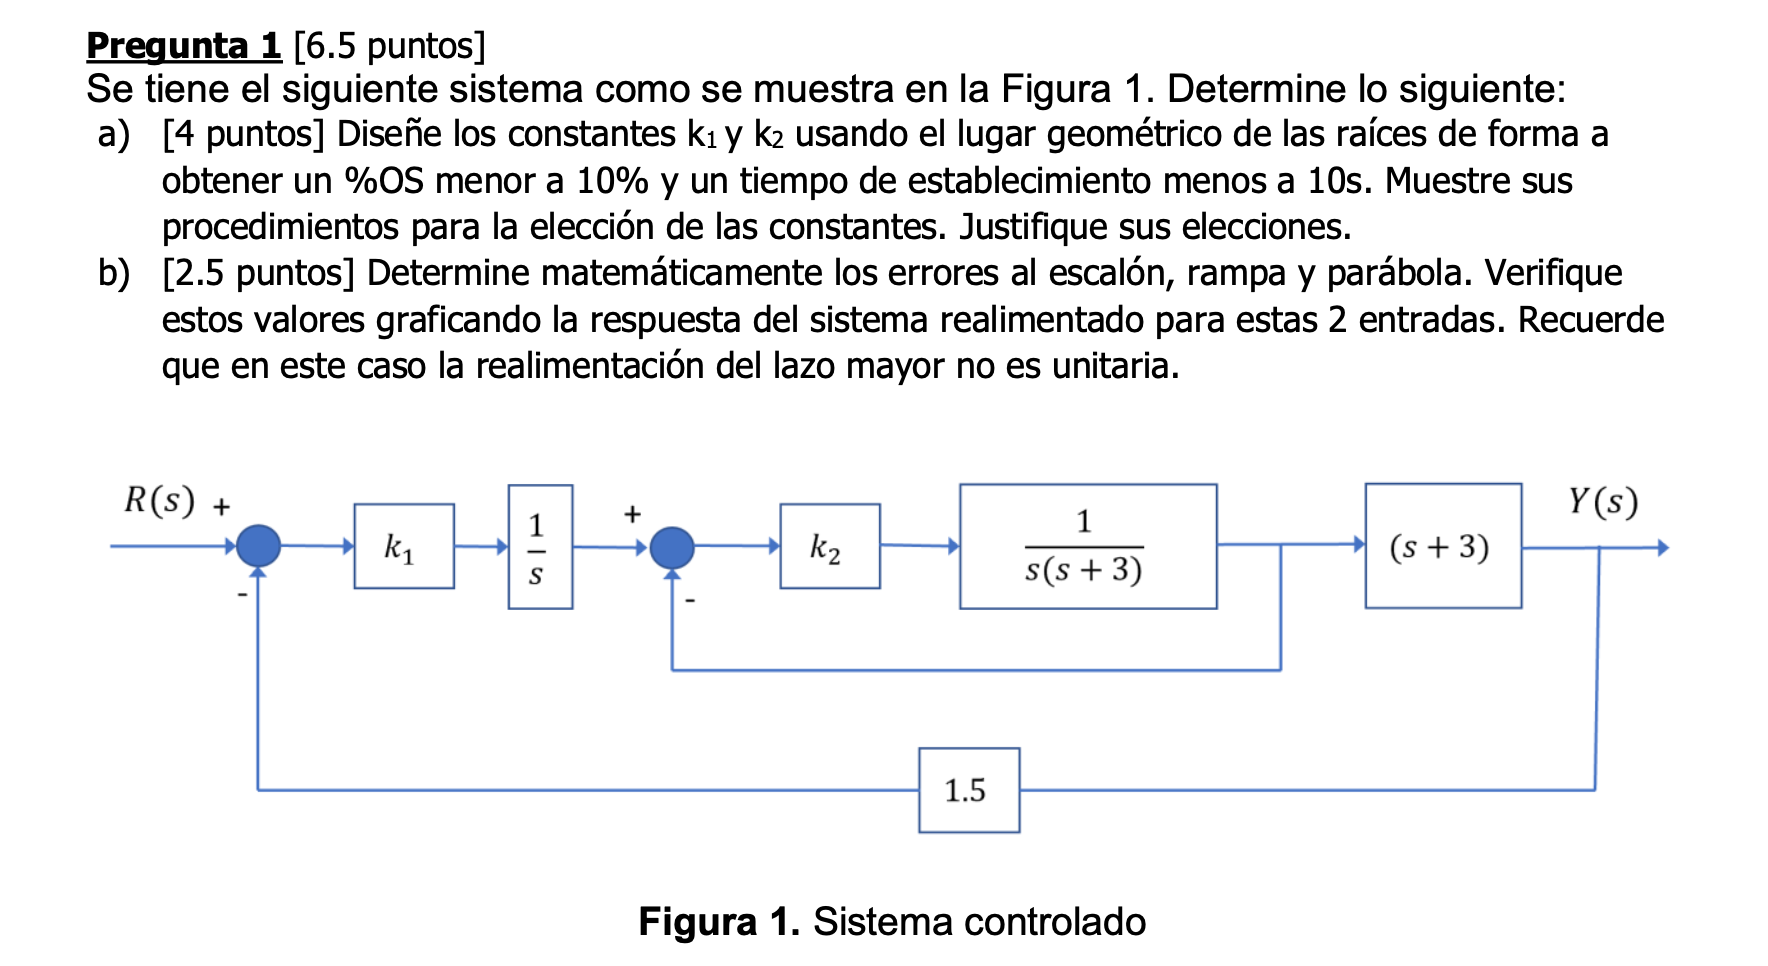

### a)  Diseñe los constantes k1 y k2 usando el lugar geométrico de las raíces de forma a obtener un %OS menor a 10% y un tiempo de establecimiento menos a 10s. Muestre sus procedimientos para la elección de las constantes. Justifique sus elecciones.

Lo primero que haré será simplificar el sistema interno

In [2]:
k1, k2 = sp.var("k_1 k_2")

In [3]:
inner_1 = k2/s/(s+3)
loop_1 = sp.simplify(inner_1/(1+inner_1))

inner_2 = sp.factor(k1/s*loop_1*(s+3))
inner_2

k_1*k_2*(s + 3)/(s*(k_2 + s**2 + 3*s))

$k_1$ y $k_2$ son constantes que deben de ser diseñadas en base a los parametros de calidad que nos piden: $PO = 10 \%$ y $Ts = 10$.

Debido a que la constante $k_2$ no puede salir del denominador, la estrategía para diseñar este controlador será fijar un valor para $k_2$ y posteriormente calcular $k_1$ usando el lugar geométrico de las raices.

Entonces,
$$ k_2 = 2.5 $$


Remplazando ese valor de $k_2$ obtenemos

In [57]:
fixed_k2 = inner_2.subs(k2, 2.5)
fixed_k2

2.5*k_1*(s + 3)/(s*(s**2 + 3*s + 2.5))

In [58]:
fixed_k2.subs(k1, 1)

2.5*(s + 3)/(s*(s**2 + 3*s + 2.5))

3.75*(s + 3)/(s*(s**2 + 3*s + 2.5))

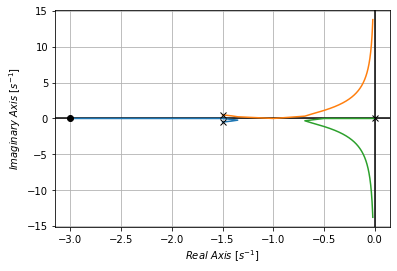

In [70]:
pre_g_sym = fixed_k2.subs(k1, 1) * 1.5 # H=1.5
display(pre_g_sym)
pre_g = ct20.core.symbolic_transfer_function(pre_g_sym)

ct20.core.plot_root_locus(pre_g, kf=50, points=3000);

In [60]:
# De los requerimientos, usaremos PO = 8% y Ts = 8s
po = 8
ts = 8

In [61]:
psi, wn = ct20.core.from_quality_to_psi_wn(po, ts)
print(f"psi= {psi} | ws= {wn}")
# con dichos parametros construiremos los polos deseados
pds = ct20.core.construct_poles(psi, wn)
print(pds)

psi= 0.6265771868559205 | ws= 0.7979862824386128
((-0.5+0.6219180870180554j), (-0.5-0.6219180870180554j))


Una vez que conocemos los polos deseados, trataremos de buscar dichos polos en los paths generados por las raices en el lugar geométrico de las raices (root locus plot). Para dicho fin, tengo una función que me permite recorrer dichos paths del root locus y buscar valores cercanos a los esperados.

* "**find_points_in_root_locus**" es análogo a la busqueda manual que se puede realizar en el root locus interactivo de matlab.

In [62]:
_ = ct20.core.find_points_in_root_locus(pre_g_sym, find=list(pds), tolerance=0.2, print_founds=True)

K = 0.100 at -0.652 + 0.489i | e = 0.142
K = 0.100 at -0.652 + -0.489i | e = 0.142
K = 0.150 at -0.585 + 0.762i | e = 0.112
K = 0.150 at -0.585 + -0.762i | e = 0.112


Como podemos ver, encontramos 4 puntos con una tolerancia de 0.1. De esos 4 puntos, los más cercanos a los polos deseados son $-0.652 + 0.489i$ y $-0.652 - 0.489i$. Y la ganancia relacionada es de $K=0.150$.

Finalmente, con este valor de ganancia podemos terminar de definir nuestro sistema, las constantes finales son:

$$ k_1=0.15 \ y \ k_2=2.5$$

In [66]:
final_inner = inner_2.subs({k1: 0.15, k2: 2.5})
final_inner

0.375*(s + 3)/(s*(s**2 + 3*s + 2.5))

In [71]:
sys = ct20.core.symbolic_transfer_function(final_inner)
feedback_sys = ct.feedback(sys, 1.5) # H = 1.5
feedback_sys


          0.125 s + 0.375
-----------------------------------
0.3333 s^3 + s^2 + 1.021 s + 0.5625

{'RiseTime': 2.133191469080967,
 'SettlingTime': 6.435527072452131,
 'SettlingMin': 0.6018106635562344,
 'SettlingMax': 0.7191040294868636,
 'Overshoot': 7.818719330118474,
 'Undershoot': 0.0,
 'Peak': 0.7191040294868636,
 'PeakTime': 4.446146264208084,
 'SteadyStateValue': 0.6669565674260299}

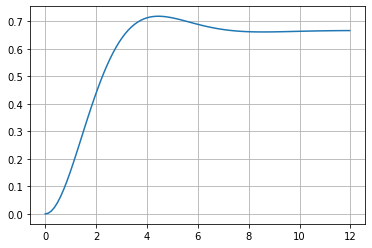

In [72]:
t, y = ct.step_response(feedback_sys)
plt.plot(t, y)
plt.grid()
ct.step_info(feedback_sys)

Como podemos ver, dicho sistema cumple con los requerimientos del problema.
$$ PO=7.8 \ y \ Ts=6.43 $$

---

### b) Determine matemáticamente los errores al escalón, rampa y parábola. Verifique estos valores graficando la respuesta del sistema realimentado para estas 2 entradas. Recuerde que en este caso la realimentación del lazo mayor no es unitaria.

Realmente no estoy seguro de entender el término "matemáticamente", lo que asumiré es que hace referencia a un cálculo teórico.

In [73]:
feedback_sys


          0.125 s + 0.375
-----------------------------------
0.3333 s^3 + s^2 + 1.021 s + 0.5625

El sistema mostrado ya se encuentra realimentado con una ganancia de 1.5

Para hallar los erroes al escalón, rampa y parabola, primero computaremos las constantes y luego los errores a partir de dichas constantes.

$$ K_p = \lim_{s\to0}G(s)H(s) \ \ y \ \ e_{p\infty}=\frac{1}{1+K_p}$$

$$ K_v = \lim_{s\to0}sG(s)H(s) \ \ y \ \ e_{v\infty}=\frac{1}{K_v}$$

$$ K_a = \lim_{s\to0}s^2G(s)H(s) \ \ y \ \ e_{a\infty}=\frac{1}{K_a}$$

In [109]:
sys_sym = (0.125*s+0.375)/(0.333*s**3+s**2+1.021*s+0.5625)

kp = sp.limit(sys_sym, s, 0)
ep = 1/(1+kp)
print("error al escalon: %.2f"%("inf" if type(ep) is sp.core.numbers.ComplexInfinity else ep))

kv = sp.limit(s*sys_sym, s, 0)
ev = 1/kv
print("error al escalon: %s"%("inf" if type(ev) is sp.core.numbers.ComplexInfinity else ev))

ka = sp.limit(s**2*sys_sym, s, 0)
ea = 1/ka
print("error al escalon: %s"%("inf" if type(ea) is sp.core.numbers.ComplexInfinity else ea))

error al escalon: 0.60
error al escalon: inf
error al escalon: inf


---

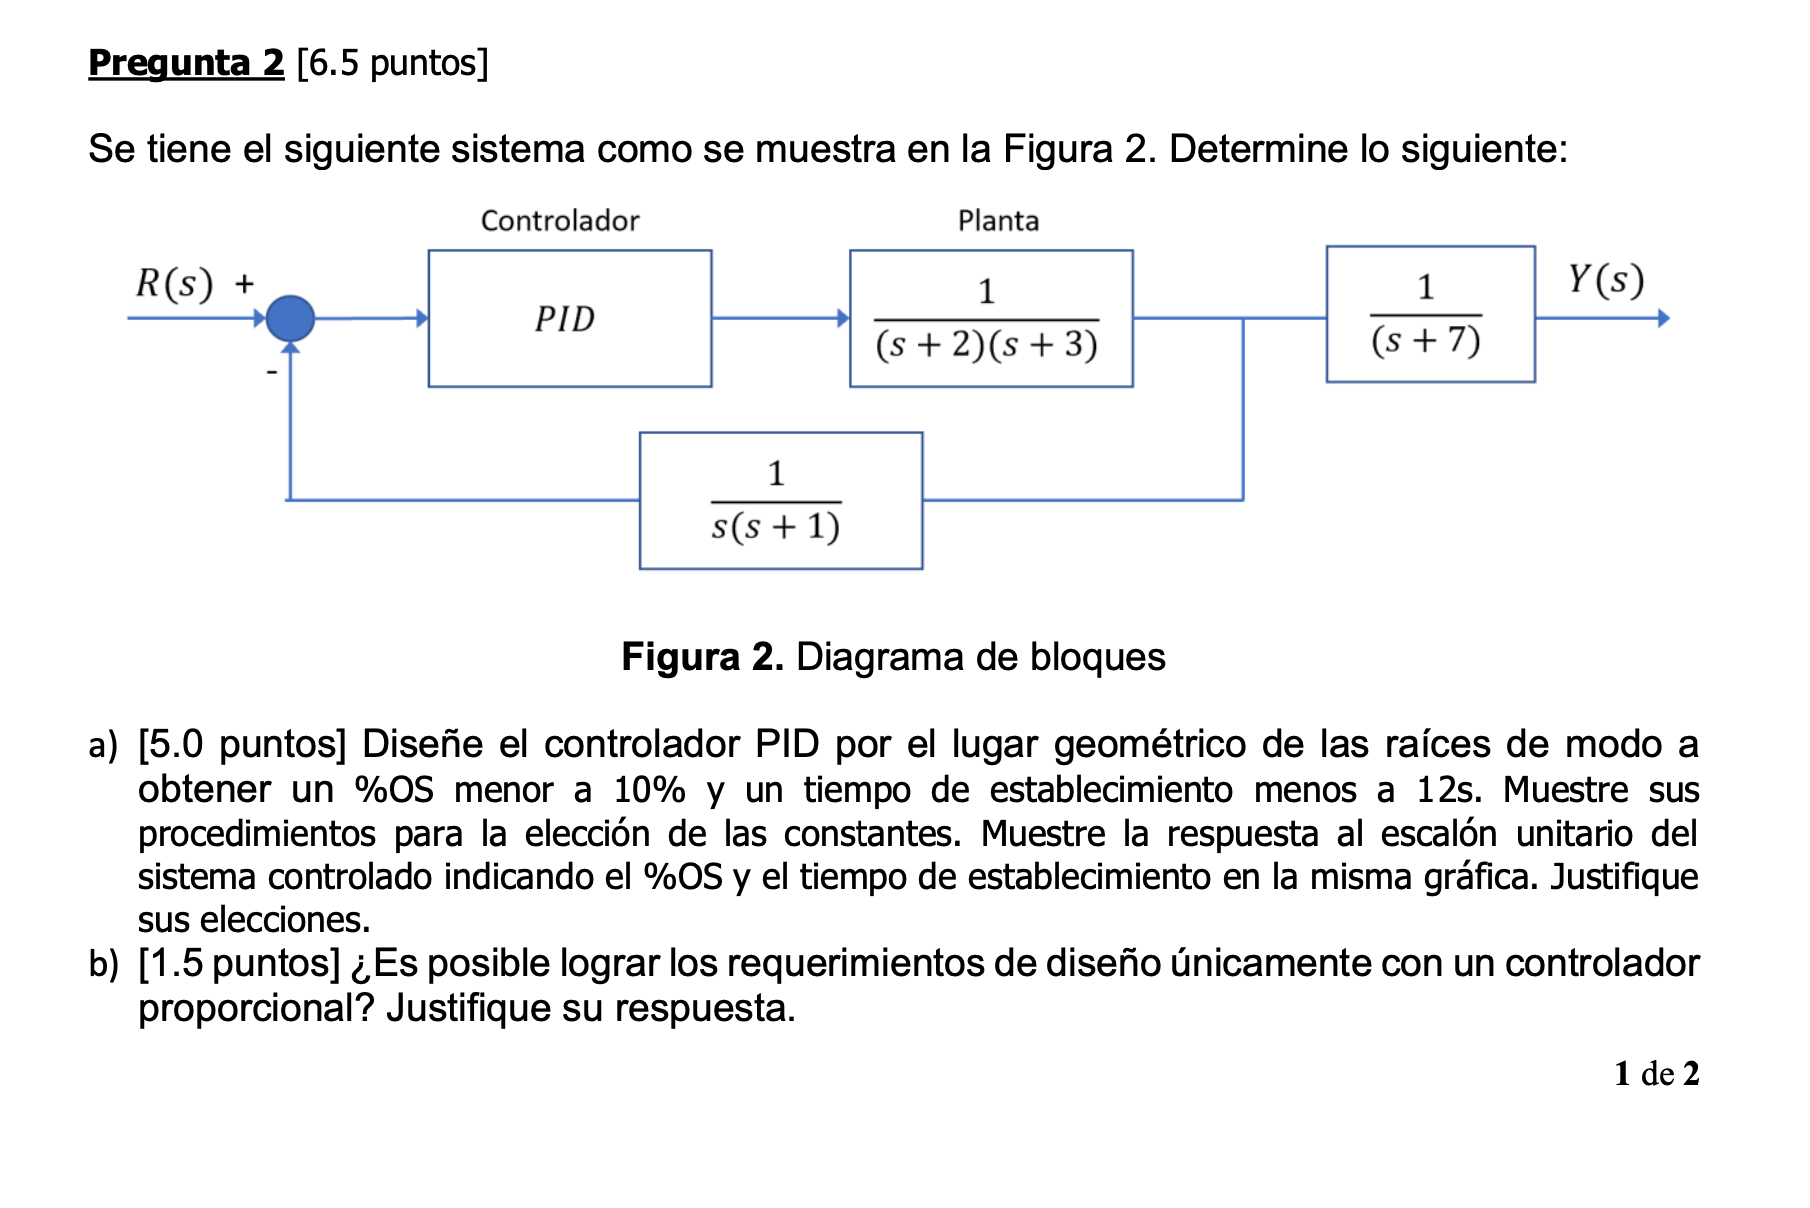

\* Nota: La función de transferencia del feedback sufrio un cambio durante el examen, su valor final es $\frac{1}{s+1}$

---

### a) Diseñe el controlador PID por el lugar geométrico de las raíces de modo a obtener un %OS menor a 10% y un tiempo de establecimiento menos a 12s. Muestre sus procedimientos para la elección de las constantes. Muestre la respuesta al escalón unitario del sistema controlado indicando el %OS y el tiempo de establecimiento en la misma gráfica. Justifique sus elecciones.

Para conseguir un sistema más estandar, podemos meter el bloque exterior al bucle interior.

Para eso, solo basta con modificar el bloque de feedback ($\frac{1}{s(s+1)}$), lo que haré será dividirlo por el bloque exterior ($\frac{1}{s+7}$).

In [112]:
plant = 1/(s+2)/(s+3)
h = 1/(s+1)
outer = 1/(s+7)

In [113]:
new_h = h/outer
display(new_h)

(s + 7)/(s + 1)

El nuevo valor de H es $\frac{s+7}{s+1}$

Entonces ahora ya puedo trabajar con un sistema más estandar...

In [114]:
g = plant*outer # new plant
display(g)

1/((s + 2)*(s + 3)*(s + 7))

Para el diseño de un PID usando el lugar geométrico de las raices, usaré la función "pid_with_root_placing" que ejecuta todo el algoritmo necesario basado en condiciones de ángulo y módulo para construir un PID usando el concepto del lugar geométrico de las raices. Implementación completa [aquí](https://github.com/bregydoc/controlsystems2020/blob/master/control2020/design/pid_root_locus.py)

Para conseguir el diseño solo tengo que introducir el sistema en su forma $G(s)H(s)$ y los parametros de de calidad (PO y Ts), en este caso, el diseño nos pide que $PO < 10\%$ y $Ts<12s$.

Yo usaré:

$$ PO = 6\% $$
$$ Ts = 8s $$

In [117]:
po = 6
ts = 8

sys = ct20.core.symbolic_transfer_function(g*new_h) # G*H

pid = ct20.design.pid_with_root_placing(sys, po, ts, report=True)
display(pid)

psi=0.67 | wn=0.75

desired pole: -0.50 + 0.56i
positioned pole angle: 16.50
found 'b' constant = -2.38
a = b, then a = -2.38 too
found 'kc' constant = 0.60
controller = 0.60 * (s+-2.38)^2 / s
pid form = 2.84 + 3.39/s + 0.60*s



0.5961 s^2 + 2.843 s + 3.39
---------------------------
             s

Veamos la respuesta al step de nuestro controlador

{'RiseTime': 1.933933933933937,
 'SettlingTime': 7.119119119119131,
 'SettlingMin': 0.12861267625944545,
 'SettlingMax': 0.1563678653243922,
 'Overshoot': 9.458412408977622,
 'Undershoot': 0.0,
 'Peak': 0.1563678653243922,
 'PeakTime': 4.260260260260267,
 'SteadyStateValue': 0.14285595952199936}

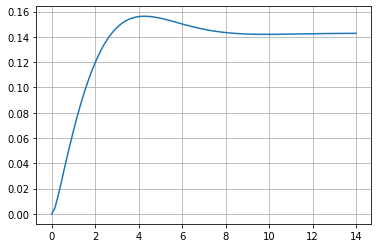

In [133]:
final_g = ct20.core.symbolic_transfer_function(g)
final_h = ct20.core.symbolic_transfer_function(new_h)

sys_feedback = pid*final_g/(1 + pid*final_g*final_h)

t, y = ct.step_response(sys_feedback)
plt.plot(t, y)
plt.grid()

ct.step_info(sys_feedback)

Como se puede apreciar, el controlador PID diseñado usando el lugar geométrico de las raices cumple con los requerimientos. 

$$ PO = 9.45\% $$
$$ Ts = 7.11s $$

### b) ¿Es posible lograr los requerimientos de diseño únicamente con un controlador proporcional? Justifique su respuesta.

Para responder esa pregunta, tenemos que comprobar si el polo deseado (calculado a partir de los requerimientos base $PO=10$ y $Ts=12$) esta cerca o se encuentra dentro del path generado por la gráfica de root locus. Veamos...

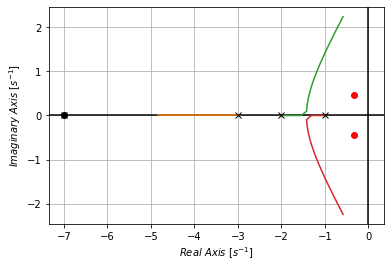

In [153]:
pds = ct20.core.construct_poles(*ct20.core.from_quality_to_psi_wn(po=10, ts=12))
ct20.core.plot_root_locus(final_g * final_h, kf=20)
plt.plot(np.real(list(pds)), np.imag(list(pds)), "ro")

Como se puede apreciar, los polos que queremos introducir al sistema (puntos en rojo) estan bastante alejados del lugar geométrico de las raices, por ende, no es posible alcanzar los requerimientos solicitados ssolo usando un control proporcional.

---

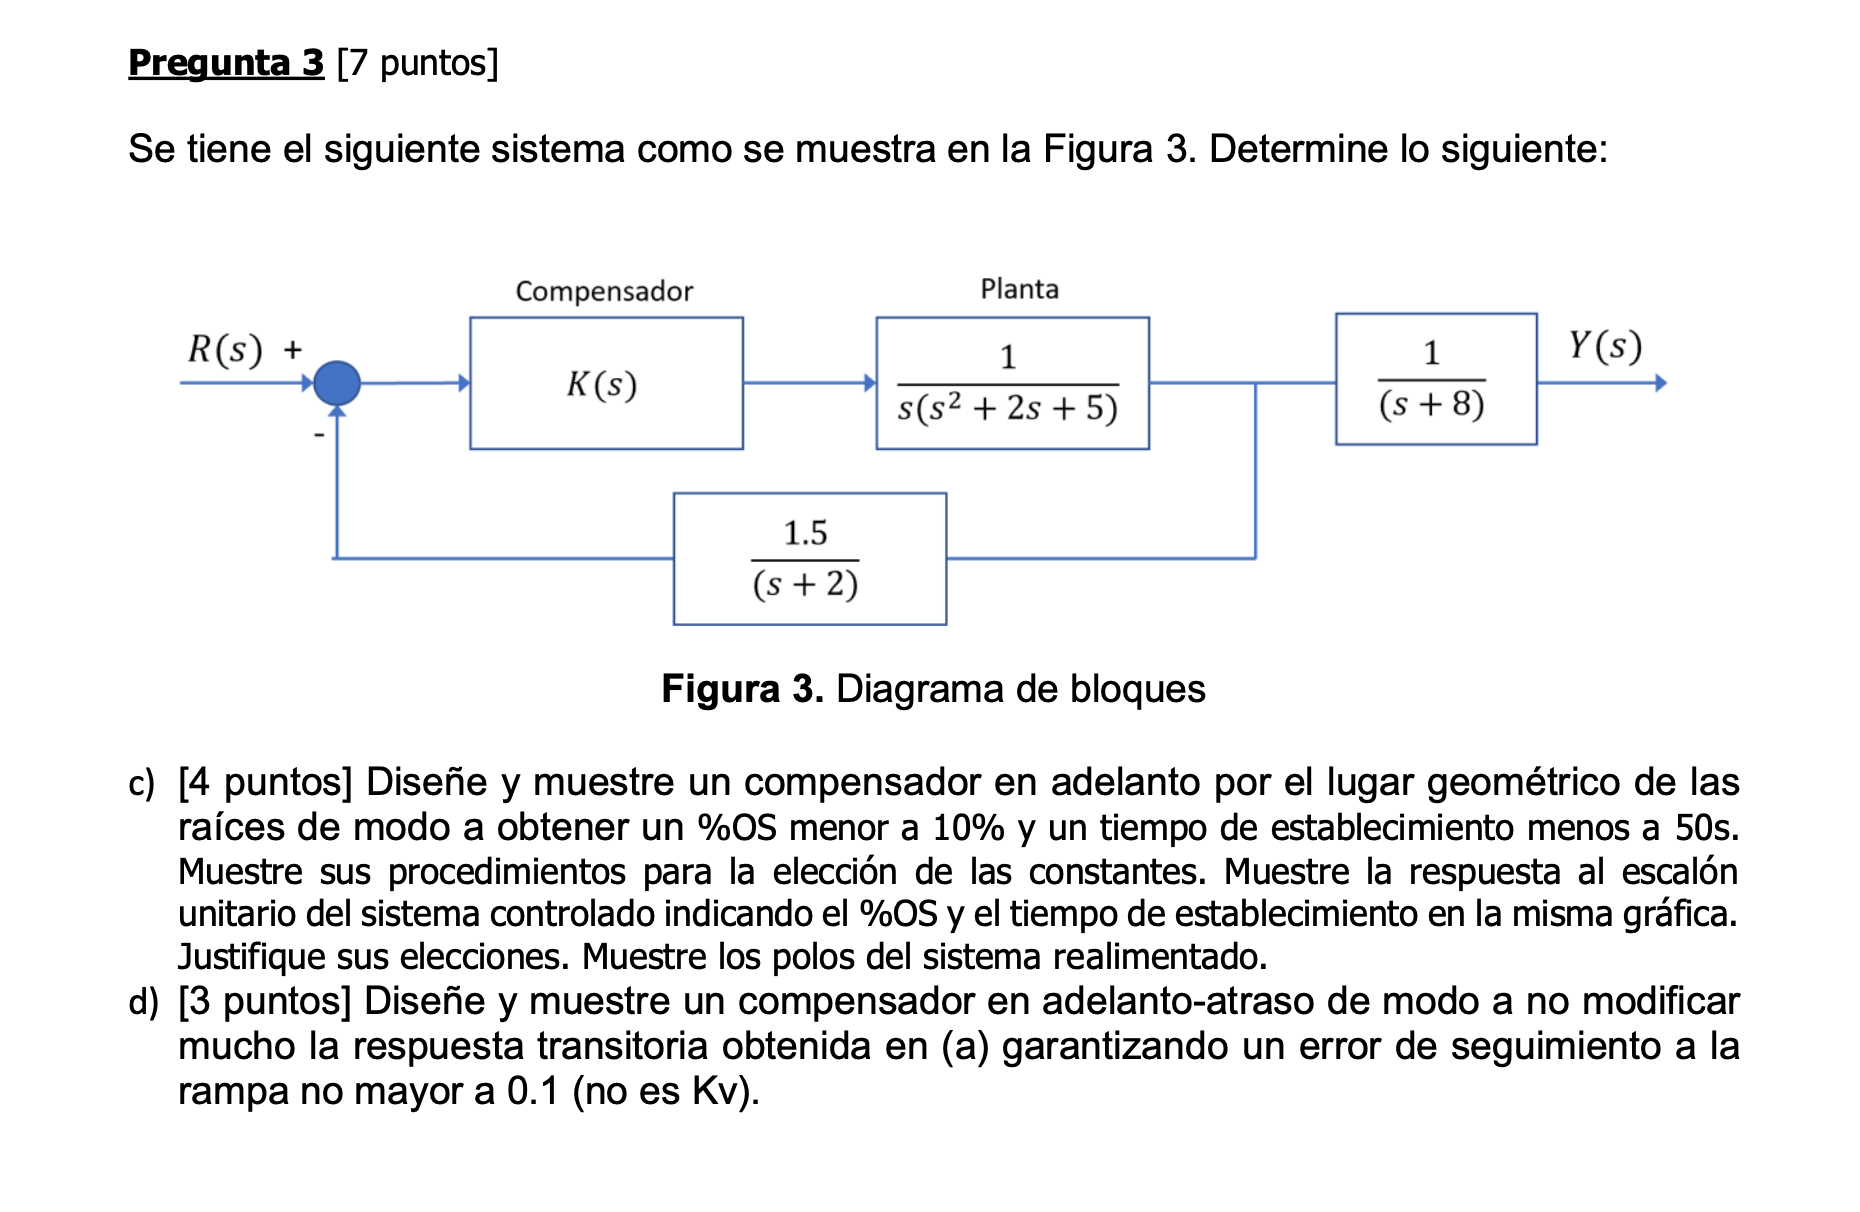

---

### a) Diseñe y muestre un compensador en adelanto por el lugar geométrico de las raíces de modo a obtener un %OS menor a 10% y un tiempo de establecimiento menos a 50s. Muestre sus procedimientos para la elección de las constantes. Muestre la respuesta al escalón unitario del sistema controlado indicando el %OS y el tiempo de establecimiento en la misma gráfica. Justifique sus elecciones. Muestre los polos del sistema realimentado.

Para construir el compensador solicitado, primero haré lo mismo que en el problema 2: cambiar la forma del sistema a uno que me permita trabajar de manera estandar. Esta vez, detallaré menos los pasos, pero en esencia es el mismo procedimiento.

In [2]:
plant = 1/s/(s**2+2*s+5)
h = 1.5/(s+2)
outer = 1/(s+8)

new_plant = plant*outer
new_h = h/outer

g = ct20.core.symbolic_transfer_function(new_plant)
hs = ct20.core.symbolic_transfer_function(new_h)

display(g)


              1
----------------------------
s^4 + 10 s^3 + 21 s^2 + 40 s

Como se puede ver arriba, la función de transferencia final de la planta es $\frac{1}{s^4+10s^3+21s^2+40s}$

Ok, para diseñar el compensador en adelanto, yo tengo una función llamada "lead_compensator_with_root_placing", dicha función ejecuta una rutina de diseño que se basa en un zero fijado al principio y posteriormente calcula el valor del polo y la constante usando la condición de ángulo y módulo. Además, a dicha función le incorporé un mecanismo de tuning que me permite "barrer" una cantidad determinada de valores para el zero del compensador y así afinar el valor de dicho zero, con la finalidad de conseguir los parametros solicitados. El modo de funcionamiento de dicho algoritmo heurístico se basa en recorrer un rango determinado alrededor de un valor de zero inicial y usando una función de error cuadrático medio modificado $err$, al final el algoritmo escoge el valor del zero que minimice dicho error.

$$err = 0.4(po - g_{po})^2 + 0.6 (ts - g_{ts})^2$$


$$po:\ PO\ esperado$$
$$g_{po}:\ PO\ encontrado$$
$$ts:\ Ts\ esperado$$
$$g_{ts}:\ Ts\ encontrado$$

Sí se quiere ahondar en la implementación, por favor dirigirse al siguiente [enlace](https://github.com/bregydoc/controlsystems2020/blob/master/control2020/design/compensator_root_locus.py), esta correctamente comentado y explicado.

Entonces, para ejecutar dicha rutina, primero determino los parametros, para este fin, escogeré 

$$PO=8\%$$
$$Ts=40s$$

a continuación, determino un valor fijo inicial para el zero

$$ zero = -0.11 $$

para ejecutar la rutina de tuning fino automática, necesito indicar el rango de tuning y yo usaré

$$ (-0.1,\ 0.1) $$

finalmente, necesito indicar la cantidad de valores a probar en ese rango, para este fin solo usaremos $100$ valores.

In [11]:
compensator = ct20.design.lead_compensator_with_root_placing(g*hs, po=8, ts=40, 
                                                             compensator_zero=-0.11,
                                                             auto_tune=True,
                                                             tune_range=(-0.1, 0.1), 
                                                             tune_values=100,
                                                             report=True)
display(compensator)

psi= 0.63 | wn= 0.16
desired poles:
-0.10 + 0.12i
-0.10 + -0.12i
compensator expected angle= 443.95
---
auto tuning zero compensator in range (-0.21, -0.01) with 100 steps
expected - ts: 40.00 | po: 8.00
step 0) zero: -0.210000 |  ts: 89.97 | po: 80.16
step 1) zero: -0.207980 |  ts: 89.39 | po: 81.21
step 2) zero: -0.205960 |  ts: 88.65 | po: 82.33
step 3) zero: -0.203939 |  ts: 88.05 | po: 83.50
step 4) zero: -0.201919 |  ts: 87.28 | po: 84.74
step 5) zero: -0.199899 |  ts: 86.50 | po: 86.05
step 6) zero: -0.197879 |  ts: 85.70 | po: 87.43
step 7) zero: -0.195859 |  ts: 84.89 | po: 88.90
step 8) zero: -0.193838 |  ts: 84.07 | po: 90.45
step 9) zero: -0.191818 |  ts: 83.23 | po: 92.11
step 10) zero: -0.189798 |  ts: 91.80 | po: 93.85
step 11) zero: -0.187778 |  ts: 91.45 | po: 95.74
step 12) zero: -0.185758 |  ts: 90.64 | po: 97.73
step 13) zero: -0.183737 |  ts: 89.95 | po: 99.87
step 14) zero: -0.181717 |  ts: 89.09 | po: 102.15
step 15) zero: -0.179697 |  ts: 88.06 | po: 104.59
step


7.767 s + 0.878
---------------
0.009772 s + 1

Despues de ejecutarse la rutina de construcción y tuning del compensador en adelanto, obtenemos el controlador de la forma $\frac{7.767s+0.878}{0.009772s+1}$, veamos su respuesta al escalon unitario y sus parametros de calidad.

{'RiseTime': 0.6735677782495839,
 'SettlingTime': 49.619492997719355,
 'SettlingMin': 0.05312522647848411,
 'SettlingMax': 0.17362021349683684,
 'Overshoot': 4.214762637936555,
 'Undershoot': 0.0,
 'Peak': 0.17362021349683684,
 'PeakTime': 1.2348742601242373,
 'SteadyStateValue': 0.16659848288483758}

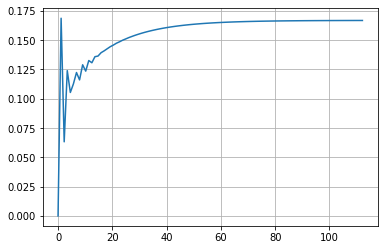

In [24]:
sys = ct.feedback(compensator*g, hs)
t, y = ct.step_response(sys)
plt.plot(t, y)
plt.grid()
ct.step_info(sys)

Como se puede ver, el compensador cumple los requerimientos esperados:

$$ PO = 4.2\% $$
$$ Ts = 49.6s $$

**Polos del sistema realimentado**

pole = -102.329 + 0.000i
pole = -8.000 + 0.000i
pole = -3.270 + 0.000i
pole = -0.335 + 2.518i
pole = -0.335 + -2.518i
pole = -0.062 + 0.000i


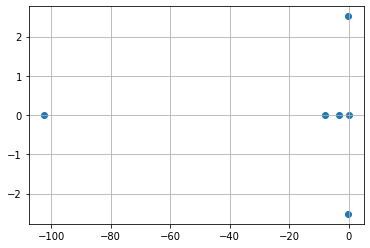

In [36]:
poles = sys.pole()
for pole in poles:
    print("pole = %.3f + %.3fi"%(pole.real, pole.imag))
plt.scatter(np.real(poles), np.imag(poles))
plt.grid()

---

### b) Diseñe y muestre un compensador en adelanto-atraso de modo a no modificar mucho la respuesta transitoria obtenida en (a) garantizando un error de seguimiento a la rampa no mayor a 0.1 (no es Kv).

In [41]:
sys


                        7.767 s^2 + 16.41 s + 1.756
----------------------------------------------------------------------------
0.009772 s^6 + 1.117 s^5 + 12.4 s^4 + 41.8 s^3 + 94.43 s^2 + 174.5 s + 10.54

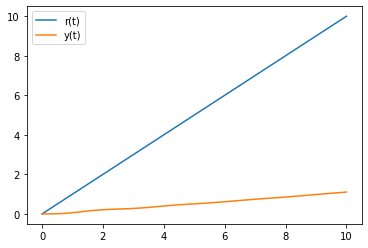

In [40]:
t = np.linspace(0, 10, 100)
t, y, _ = ct.forced_response(sys, t, t)
plt.plot(t, t)
plt.plot(t, y)
plt.legend(["r(t)", "y(t)"])

Realizando un rápido analisis empírico y añadiendole un lag compensator al systema, observo que no hay manera de conseguir el requerimiento de error de seguimiento a la rampa.

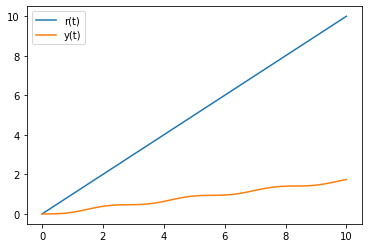

In [81]:
lag_compensator = ct.TransferFunction([1, 1.52], [1, 0.005])
new_sys = ct.feedback(lag_compensator*compensator*g, hs)
t = np.linspace(0, 10, 100)
t, y, _ = ct.forced_response(new_sys, t, t)
plt.plot(t, t)
plt.plot(t, y)
plt.legend(["r(t)", "y(t)"])